# Day 5: LSTM模型训练

实现和训练LSTM模型，对比TextCNN的结果


In [ ]:
# Cell 1: 导入库
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# 导入模型和数据集
from src.models.lstm import LSTMClassifier
from src.utils.dataset import TextDataset

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 检查GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
print("导入成功")


使用设备: cuda
导入成功


In [ ]:
# Cell 2: 加载数据（复用之前的）
print("加载数据...")

train_dataset = TextDataset('../data/processed/train_processed.pkl')
val_dataset = TextDataset('../data/processed/val_processed.pkl')
test_dataset = TextDataset('../data/processed/test_processed.pkl')

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 读取词表
with open('../data/processed/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

print(f"\n训练集: {len(train_dataset)} 条")
print(f"验证集: {len(val_dataset)} 条")
print(f"测试集: {len(test_dataset)} 条")
print(f"词表大小: {len(vocab):,}")
print("数据加载完成")


加载数据...
加载数据: 45462 条
加载数据: 9742 条
加载数据: 9743 条

训练集: 45462 条
验证集: 9742 条
测试集: 9743 条
词表大小: 117,355
数据加载完成


In [ ]:
# Cell 3: 初始化LSTM模型
print("初始化LSTM模型...")

model = LSTMClassifier(
    vocab_size=len(vocab),
    embed_dim=300,
    hidden_size=256,
    num_layers=2,
    num_classes=14,
    dropout=0.5,
    bidirectional=True  # 双向LSTM
)

model = model.to(device)

# 打印模型结构
print(model)
print(f"\n模型参数量: {sum(p.numel() for p in model.parameters()):,}")
print("LSTM模型初始化完成")


初始化LSTM模型...
LSTMClassifier(
  (embedding): Embedding(117355, 300)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=14, bias=True)
)

模型参数量: 37,933,426
LSTM模型初始化完成


In [ ]:
# Cell 4: 训练和评估函数（复用）

def train_epoch(model, dataloader, criterion, optimizer, device):
    """训练一个epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for ids, labels in tqdm(dataloader, desc='Training'):
        ids = ids.to(device)
        labels = labels.to(device)
        
        outputs = model(ids)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        # 梯度裁剪（防止梯度爆炸，LSTM常用）
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy


def evaluate(model, dataloader, criterion, device):
    """评估模型"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for ids, labels in tqdm(dataloader, desc='Evaluating'):
            ids = ids.to(device)
            labels = labels.to(device)
            
            outputs = model(ids)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy

print("训练函数定义完成")


训练函数定义完成


In [ ]:
# Cell 5: 训练配置
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2
)

num_epochs = 10
best_val_acc = 0

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("训练配置完成")
print(f"  Epochs: {num_epochs}")
print(f"  Batch size: {batch_size}")
print(f"  Learning rate: 0.001")
print(f"  Optimizer: Adam")
print(f"  Device: {device}")


训练配置完成
  Epochs: 10
  Batch size: 64
  Learning rate: 0.001
  Optimizer: Adam
  Device: cuda


In [ ]:
# Cell 6: 开始训练LSTM！
print("="*60)
print("开始训练LSTM模型")
print("="*60)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 40)
    
    # 训练
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # 验证
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    # 记录
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # 打印
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # 保存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '../output/lstm_best.pth')
        print(f"保存最佳模型 (Val Acc: {val_acc:.2f}%)")
    
    # 学习率调度
    scheduler.step(val_acc)

print("\n" + "="*60)
print("LSTM训练完成！")
print("="*60)
print(f"最佳验证准确率: {best_val_acc:.2f}%")


开始训练LSTM模型

Epoch 1/10
----------------------------------------


Evaluating: 100%|██████████| 153/153 [00:13<00:00, 11.25it/s]


Train Loss: 0.7263, Train Acc: 78.06%
Val Loss: 0.3569, Val Acc: 89.79%
保存最佳模型 (Val Acc: 89.79%)

Epoch 2/10
----------------------------------------


Evaluating: 100%|██████████| 153/153 [00:09<00:00, 15.52it/s]


Train Loss: 0.2395, Train Acc: 93.19%
Val Loss: 0.2809, Val Acc: 92.07%
保存最佳模型 (Val Acc: 92.07%)

Epoch 3/10
----------------------------------------


Evaluating: 100%|██████████| 153/153 [00:08<00:00, 17.88it/s]


Train Loss: 0.1309, Train Acc: 96.22%
Val Loss: 0.2581, Val Acc: 92.96%
保存最佳模型 (Val Acc: 92.96%)

Epoch 4/10
----------------------------------------


Evaluating: 100%|██████████| 153/153 [00:09<00:00, 15.64it/s]


Train Loss: 0.0672, Train Acc: 98.10%
Val Loss: 0.2775, Val Acc: 92.95%

Epoch 5/10
----------------------------------------


Evaluating: 100%|██████████| 153/153 [00:08<00:00, 17.25it/s]


Train Loss: 0.0389, Train Acc: 98.94%
Val Loss: 0.3075, Val Acc: 92.65%

Epoch 6/10
----------------------------------------


Evaluating: 100%|██████████| 153/153 [00:13<00:00, 11.32it/s]


Train Loss: 0.0317, Train Acc: 99.08%
Val Loss: 0.3173, Val Acc: 93.27%
保存最佳模型 (Val Acc: 93.27%)

Epoch 7/10
----------------------------------------


Evaluating: 100%|██████████| 153/153 [00:09<00:00, 15.56it/s]


Train Loss: 0.0225, Train Acc: 99.33%
Val Loss: 0.3436, Val Acc: 92.78%

Epoch 8/10
----------------------------------------


Evaluating: 100%|██████████| 153/153 [00:13<00:00, 11.54it/s]


Train Loss: 0.0228, Train Acc: 99.31%
Val Loss: 0.4006, Val Acc: 92.35%

Epoch 9/10
----------------------------------------


Evaluating: 100%|██████████| 153/153 [00:10<00:00, 14.30it/s]


Train Loss: 0.0165, Train Acc: 99.52%
Val Loss: 0.3639, Val Acc: 93.44%
保存最佳模型 (Val Acc: 93.44%)

Epoch 10/10
----------------------------------------


Evaluating: 100%|██████████| 153/153 [00:15<00:00,  9.60it/s]


Train Loss: 0.0138, Train Acc: 99.62%
Val Loss: 0.3516, Val Acc: 93.18%

LSTM训练完成！
最佳验证准确率: 93.44%


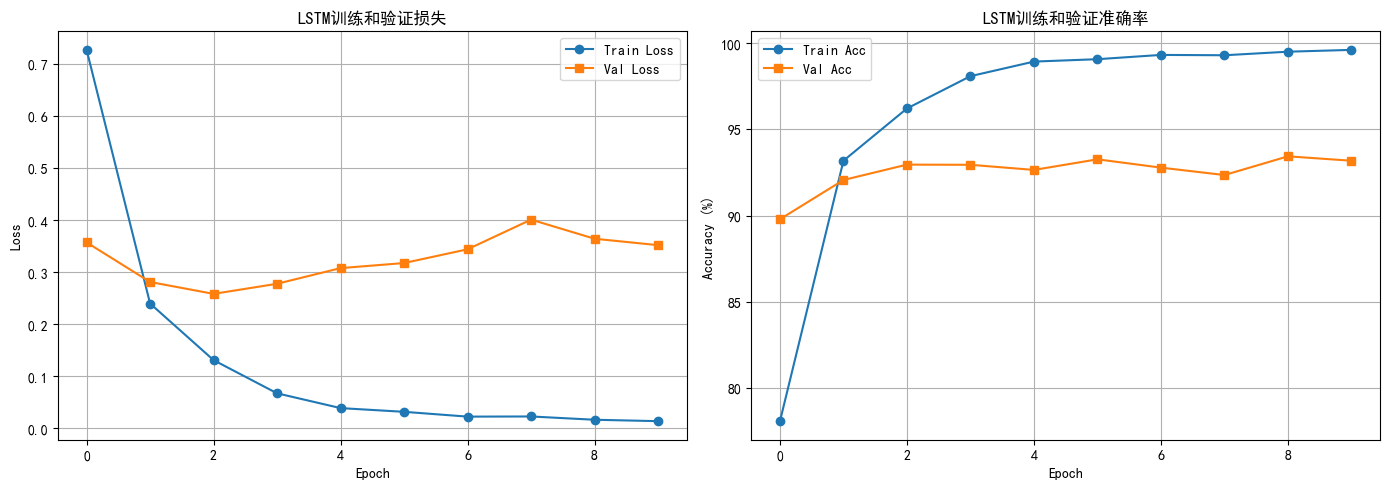

 训练曲线已保存


In [ ]:
# Cell 7: 可视化训练曲线
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 损失曲线
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('LSTM训练和验证损失')
ax1.legend()
ax1.grid(True)

# 准确率曲线
ax2.plot(history['train_acc'], label='Train Acc', marker='o')
ax2.plot(history['val_acc'], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('LSTM训练和验证准确率')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('../output/lstm_training_curve.png', dpi=150)
plt.show()

print(" 训练曲线已保存")


In [ ]:
# Cell 8: 测试集评估
print("在测试集上评估LSTM...")

model.load_state_dict(torch.load('../output/lstm_best.pth'))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print("\n" + "="*60)
print("LSTM模型最终结果")
print("="*60)
print(f"测试集准确率: {test_acc:.2f}%")
print(f"测试集损失: {test_loss:.4f}")
print("="*60)

print("\n LSTM训练和评估完成！")


在测试集上评估LSTM...


Evaluating: 100%|██████████| 153/153 [00:07<00:00, 20.39it/s]


LSTM模型最终结果
测试集准确率: 93.47%
测试集损失: 0.3154

 LSTM训练和评估完成！


In [ ]:
# Cell 9: 对比TextCNN vs LSTM
import pandas as pd

print("="*60)
print(" TextCNN vs LSTM 对比")
print("="*60)

# 创建对比表格
results = {
    '模型': ['TextCNN', 'LSTM'],
    '验证集准确率': [94.83, best_val_acc],  # TextCNN的结果，LSTM的best_val_acc
    '测试集准确率': [94.74, test_acc],
    '参数量': ['3.9M', f'{sum(p.numel() for p in model.parameters())/1e6:.1f}M'],
    
}

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

print("\n 对比分析:")
print(f"  - LSTM比TextCNN准确率{'高' if best_val_acc > 94.83 else '低'} {abs(best_val_acc-94.83):.2f}%")
print(f"  - LSTM参数量更{'多' if sum(p.numel() for p in model.parameters()) > 3.9e6 else '少'}")
print(f"  - LSTM能捕捉序列信息，TextCNN提取局部特征")




 TextCNN vs LSTM 对比
     模型    验证集准确率    测试集准确率   参数量
TextCNN 94.830000 94.740000  3.9M
   LSTM 93.440772 93.472236 37.9M

 对比分析:
  - LSTM比TextCNN准确率低 1.39%
  - LSTM参数量更多
  - LSTM能捕捉序列信息，TextCNN提取局部特征
